# PyTorch를 사용한 Convolution neural network

"딥러닝"은 일반적으로 인간의 두뇌가 학습하고 결정을 내리는 방식을 합성하는 여러 계층이있는 신경망을 사용하는 일반적인 용어입니다. *convolution neural network*(합성곱 신경망, CNN)은 가중치를 적용하고 가장자리, 모서리 등과 같은 패턴을 식별하기 위해 행렬 값에 대해 여러 필터를 거치고 계산하여 숫자 값의 행렬에서 *feature*(특징)을 추출하는 일종의 신경망입니다. 그런 다음 이러한 패턴의 숫자 표현이 완전히 연결된 신경망 계층으로 전달되어 기능을 특정 클래스에 매핑합니다.

CNN을 만드는데 일반적으로 사용되는 여러 프레임워크가 있습니다. 이 노트북에서는 PyTorch를 사용하여 간단한 예제로 CNN을 빌드합니다.

## 라이브러리 가져 오기

먼저 필요한 PyTorch 라이브러리를 설치하고 가져옵니다.

In [1]:
#!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.8.1


## 데이터 탐색

이번 실습에서는 기하학적 모양의 이미지를 분류하는 CNN기반 분류 모델을 학습 하려고 합니다. 모델이 식별해야하는 기하학 모양의 클래스들을 살펴 보겠습니다.

3 classes:
['circle', 'square', 'triangle']


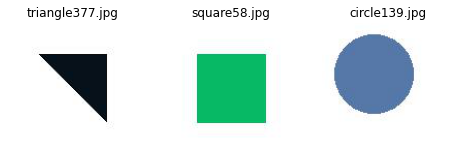

In [3]:
# The images are in the data/shapes folder
data_path = 'data/shapes/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## 데이터 불러오기

PyTorch에는 데이터 로드 및 변환 함수가 있습니다. 이를 사용하여 학습 데이터용 반복 로더(iterator loader)를 만들고 테스트 데이터용 두 번째 반복 로더(학습된 모델의 유효성을 검사하는데 사용)를 만듭니다. loader는 이미지 데이터를 PyTorch에서 사용되는 핵심 데이터 구조 인 *텐서*로 변환하고, 픽셀 값이 평균 0.5와 표준 편차 0.5의 척도로 정규화합니다.

다음 셀을 실행하여 데이터로더(DataLoader)를 정의하십시오.

In [4]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


## CNN 정의

PyTorch에서 신경망 모델을 **nn.Module** 기본 클래스에서 파생된 클래스로 정의합니다. 클래스는 네트워크(neural net)의 레이어(layer)를 정의하고 네트워크의 레이어를 통해 데이터를 처리하는데 사용되는 **forward** 메서드를 정의 해야합니다.

In [5]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


## 모델 학습

이제 네트워크(모델) 클래스를 정의 했으므로 이미지 데이터를 사용하여 훈련 할 수 있습니다.

학습은 훈련데이터가 네트워크의 계층에 의해 배치로 처리되고 옵티마이저가 뒤로 돌아가 가중치를 조정(=역전파)하는 반복적인 일련의 순방향 패스로 구성됩니다. 또한 별도의 테스트 이미지 세트를 사용하여 각 반복 (또는 *epoch*)이 끝날 때 마다 모델을 테스트하여 모델 성능을 추적할 수 있습니다.

아래 예에서는 데이터 로더에 의해 로드된 이미지 배치(*batch*)를 사용하여 모델을 훈련하기 위해 5개의 epoch를 사용하고, 이때 훈련 데이터 로더만 사용되고 테스트 데이터 로더는 학습에 사용하지 않고 보류 해 둡니다. 각 Epoch 후에 손실 함수는 모델의 오류 (*loss*)를 측정하고 가중치(첫 번째 반복에서 무작위로 생성됨)를 조정하여 정확도를 개선합니다.

> **참고**: 이 간단한 예제에서는 훈련 시간을 최소화하기 위해 5개의 Epoch만 사용합니다. 실제 CNN은 일반적으로 이보다 더 많은 시대에 걸쳐 훈련됩니다. CNN 모델 학습은 많은 행렬 및 벡터 기반 작업에 프로세서를 많이 사용하기 때문에, 이러한 종류의 계산에 최적화된 GPU를 활용할 수있는 시스템에서이 작업을 수행하는 것이 좋습니다. CPU 기반 시스템에서 완료하는 데 시간이 걸립니다. 교육이 진행됨에 따라 상태가 표시됩니다.

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/840 (0%)] Loss: 1.096307
Training set [500/840 (59%)] Loss: 0.863946
Training set: Average loss: 0.855090
Validation set: Average loss: 0.485281, Accuracy: 276/360 (77%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.550072
Training set [500/840 (59%)] Loss: 0.491098
Training set: Average loss: 0.385324
Validation set: Average loss: 0.355010, Accuracy: 305/360 (85%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.538237
Training set [500/840 (59%)] Loss: 0.368219
Training set: Average loss: 0.275169
Validation set: Average loss: 0.212325, Accuracy: 330/360 (92%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.215296
Training set [500/840 (59%)] Loss: 0.231504
Training set: Average loss: 0.192746
Validation set: Average loss: 0.145521, Accuracy: 344/360 (96%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.123567
Training set [500/840 (59%)] Loss: 0.104940
Training set: Average loss: 0.093976
Validation set: Average loss: 0.057046, Accuracy: 360/360 (100%)



## Loss(손실) 확인하기

각 epoch에 대한 평균 훈련 및 검증 손실을 추적합니다. 그 이유는 모델이 학습됨에 따라 손실이 감소했는지 확인하고 *과적합* (검증 데이터의 손실이 평준화 되거나 증가하기 시작한 후에도 학습 데이터의 손실이 계속적으로 감소함을 나타냄)을 감지하기 위해 이를 시각화 하여 살펴봅니다.

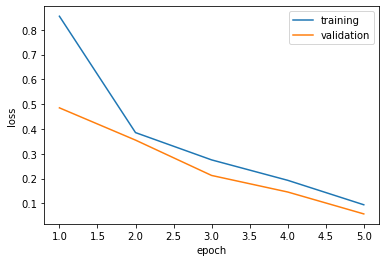

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 모델 성능 평가

테스트 데이터를 기반으로 최종 정확도를 볼 수 있지만 일반적으로 성능 메트릭을 좀 더 자세히 살펴 보는게 좋습니다. 모델이 각 클래스를 얼마나 잘 예측하는지 확인하기 위해 confusion matrix(혼동 행렬)을 시각화 해 보겠습니다.

Getting predictions from test set...


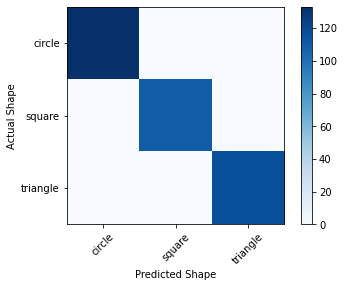

In [9]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## 훈련 된 모델 저장

모델을 나중에 사용할 수 있도록 학습된 가중치를 저장할 수 있습니다.

In [10]:
# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/shape_classifier.pt


## 훈련된 모델 사용

이제 모델을 저장 했으므로, 새로운 이미지의 클래스를 예측하는데 사용할 수 있습니다.

square


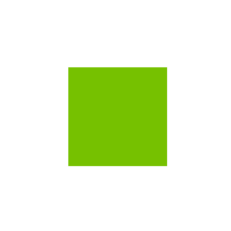

In [11]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])

## 더 읽을 거리

PyTorch를 사용한 CNN에 대한 자세한 내용은 [PyTorch 문서](https://pytorch.org/).를 참고 하세요.

## 과제 : Safari 이미지 분류

이 노트북 실습이 CNN 교육 및 평가의 주요 단계를 보여 주었기를 바라며, [/ challenges / 05-Safari CNN Challenge.ipynb](./challenges/05%20-%20Safari%20CNN%20Challenge.ipynb) 노트북에서 Safari 이미지 분류 챌린지를 통해 배운 내용을 실행하는 것도 좋아보입니다.

> **참고**: 이 옵션 챌린지를 완료하는 데 걸리는 시간은이 연습의 예상 시간에 포함되지 않습니다. 원하는만큼 시간을 적게 또는 많이 사용할 수 있습니다!